In [104]:
# IMDb Indian Movies Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [105]:
# 1. Data Loading
df = pd.read_csv('IMDb Movies India.csv', encoding='cp1252')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (15509, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB

Missing Values:
Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


In [106]:
# 2. Data Cleaning

# Function to clean duration format
def clean_duration(duration):
    try:
        if pd.isna(duration):
            return np.nan
        # Extract numbers from string
        duration = ''.join(filter(str.isdigit, str(duration)))
        return float(duration) if duration else np.nan
    except:
        return np.nan


In [107]:
# Function to clean year format
def clean_year(year):
    try:
        if year is None:
            return None
        year = str(year).strip()
        year = re.sub(r'[()]', '', year)  # Remove '(' and ')'
        return int(year) if year.isdigit() else None
    except:
        return None

In [108]:
# Function to clean votes format
def clean_votes(votes):
    try:
        if pd.isna(votes):
            return np.nan
        # Remove commas and convert to integer
        return int(str(votes).replace(',', ''))
    except:
        return np.nan

In [109]:
# Apply cleaning functions
df['Duration'] = df['Duration'].apply(clean_duration)
df['Year'] = df['Year'].apply(clean_year)
df['Votes'] = df['Votes'].apply(clean_votes)

In [110]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),2019.0,109.0,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,2021.0,90.0,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,2019.0,110.0,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,2010.0,105.0,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [111]:
# Clean genre by splitting into list
df['Genre'] = df['Genre'].fillna('Unknown')
df['Genre'] = df['Genre'].str.split(',')

In [112]:
# 3. Data Analysis and Visualization

# Create a new notebook section for EDA
print("\nExploratory Data Analysis")
print("-" * 50)

# Basic statistics
print("\nNumerical Columns Statistics:")
print(df.describe())


Exploratory Data Analysis
--------------------------------------------------

Numerical Columns Statistics:
               Year     Duration       Rating          Votes
count  14981.000000  7240.000000  7919.000000    7919.000000
mean    1987.012215   128.126519     5.841621    1938.520394
std       25.416689    28.912724     1.381777   11602.415952
min     1913.000000     2.000000     1.100000       5.000000
25%     1968.000000   110.000000     4.900000      16.000000
50%     1991.000000   131.000000     6.000000      55.000000
75%     2009.000000   147.000000     6.800000     404.000000
max     2022.000000   321.000000    10.000000  591417.000000


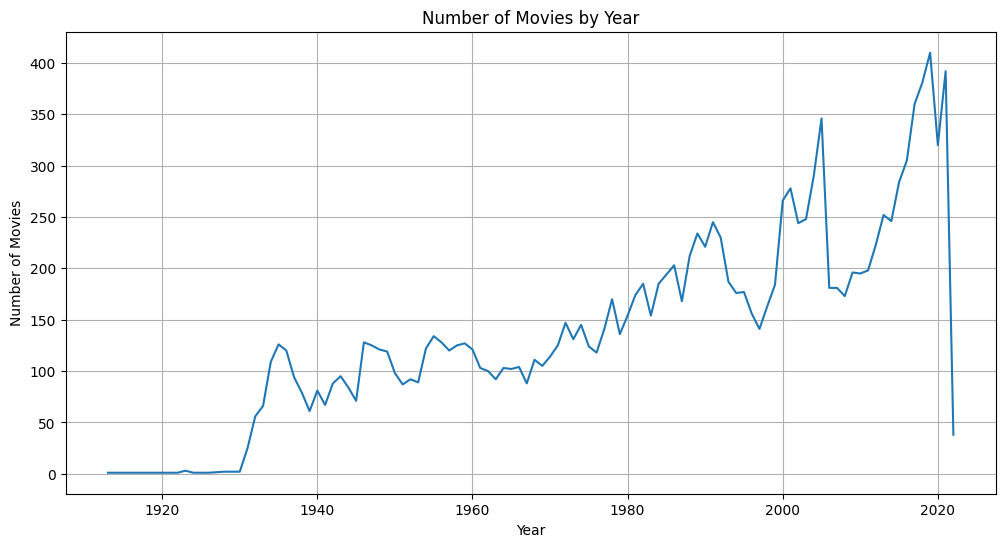

In [113]:

# Year distribution
plt.figure(figsize=(12, 6))
df['Year'].value_counts().sort_index().plot(kind='line')
plt.title('Number of Movies by Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

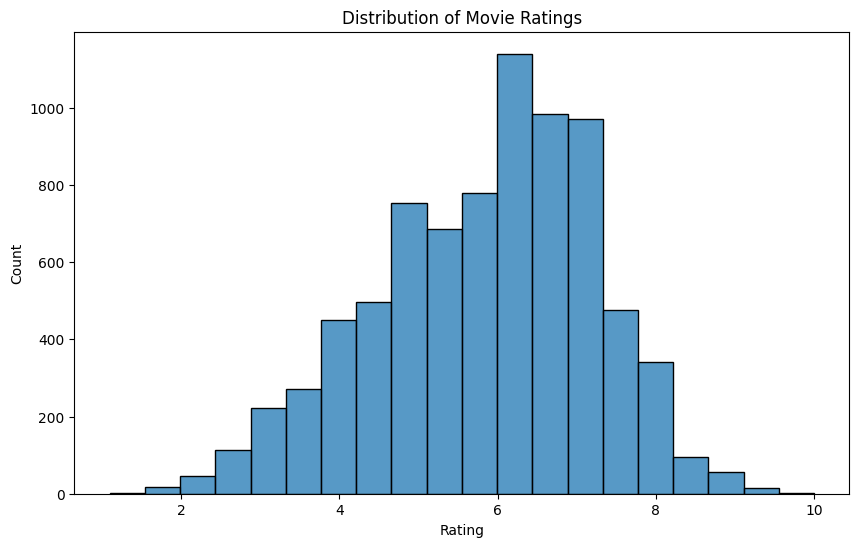

In [114]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Rating', bins=20)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

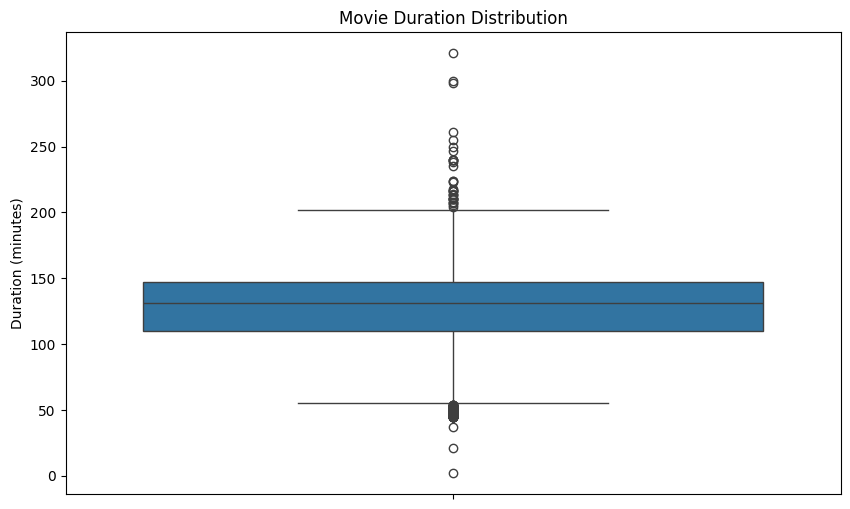

In [115]:
# Duration analysis
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='Duration')
plt.title('Movie Duration Distribution')
plt.ylabel('Duration (minutes)')
plt.show()


In [116]:
# Top directors by average rating (minimum 5 movies)
director_stats = df.groupby('Director').agg({
    'Name': 'count',
    'Rating': 'mean'
}).reset_index()

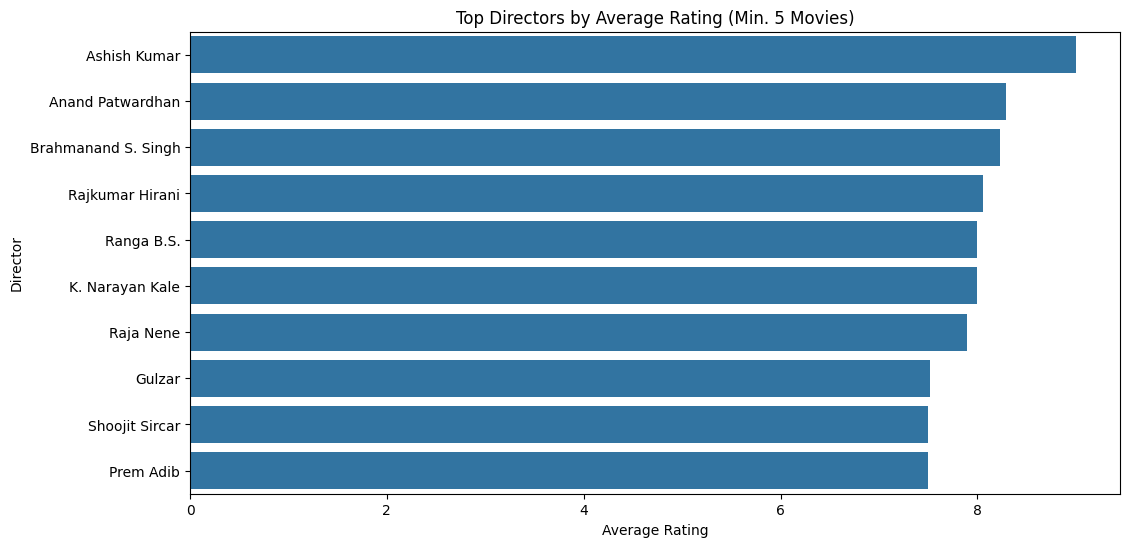

In [117]:
top_directors = director_stats[director_stats['Name'] >= 5].sort_values('Rating', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_directors, x='Rating', y='Director')
plt.title('Top Directors by Average Rating (Min. 5 Movies)')
plt.xlabel('Average Rating')
plt.show()


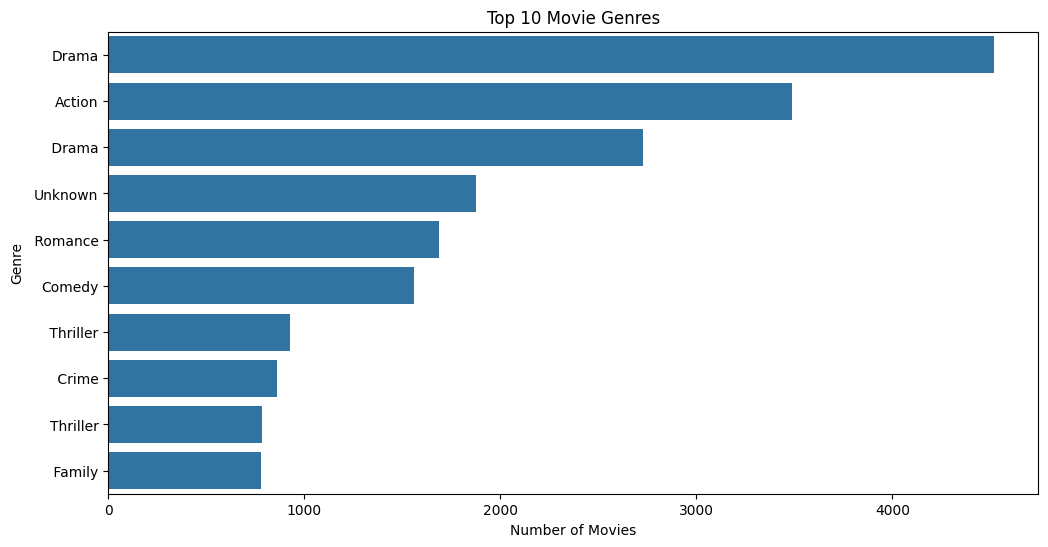

In [118]:
# Genre analysis
# Explode genre lists into separate rows
genre_df = df.explode('Genre')
genre_counts = genre_df['Genre'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Top 10 Movie Genres')
plt.xlabel('Number of Movies')
plt.show()

In [119]:
# Actor analysis
def get_actor_stats(actor_column):
    return df.groupby(actor_column).agg({
        'Name': 'count',
        'Rating': 'mean'
    }).reset_index()

# Combine stats for all actors
actor_stats = pd.concat([
    get_actor_stats('Actor 1'),
    get_actor_stats('Actor 2'),
    get_actor_stats('Actor 3')
])

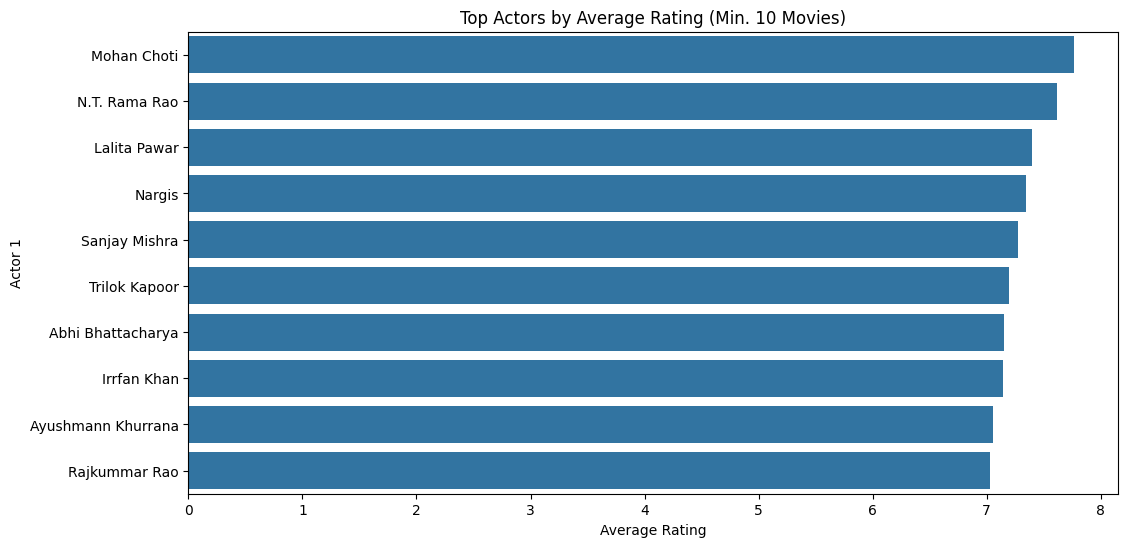

In [120]:
# Group by actor and calculate average stats
actor_summary = actor_stats.groupby(actor_stats.columns[0]).agg({
    'Name': 'sum',
    'Rating': 'mean'
}).reset_index()

# Get top actors by number of movies (minimum 10 movies)
top_actors = actor_summary[actor_summary['Name'] >= 10].sort_values('Rating', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_actors, x='Rating', y=top_actors.columns[0])
plt.title('Top Actors by Average Rating (Min. 10 Movies)')
plt.xlabel('Average Rating')
plt.show()

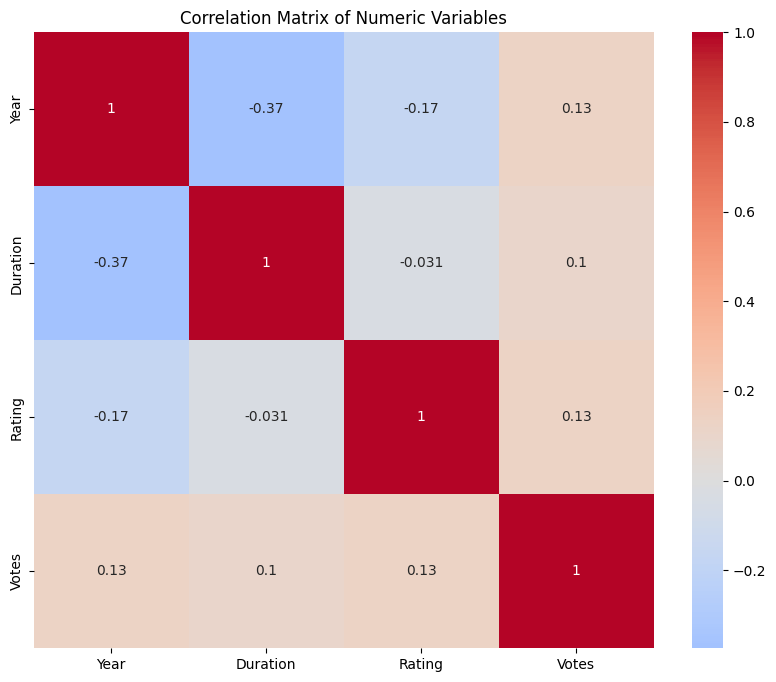

In [121]:
# 4. Correlation Analysis
numeric_cols = ['Year', 'Duration', 'Rating', 'Votes']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

In [122]:
# 5. Summary of Findings
print("\nKey Findings:")
print("-" * 50)
print(f"1. Total number of movies: {len(df)}")
print(f"2. Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"3. Average movie rating: {df['Rating'].mean():.2f}")
print(f"4. Average movie duration: {df['Duration'].mean():.2f} minutes")
print(f"5. Most common genre: {genre_counts.index[0]}")
print(f"6. Director with highest average rating (min 5 movies): {top_directors.iloc[0]['Director']}")
print(f"7. Actor with highest average rating (min 10 movies): {top_actors.iloc[0][top_actors.columns[0]]}")

# Save cleaned dataset
df.to_csv('cleaned_imdb_movies_india.csv', index=False)
print("\nCleaned dataset has been saved as 'cleaned_imdb_movies_india.csv'")


Key Findings:
--------------------------------------------------
1. Total number of movies: 15509
2. Year range: 1913.0 - 2022.0
3. Average movie rating: 5.84
4. Average movie duration: 128.13 minutes
5. Most common genre: Drama
6. Director with highest average rating (min 5 movies): Ashish Kumar
7. Actor with highest average rating (min 10 movies): Mohan Choti

Cleaned dataset has been saved as 'cleaned_imdb_movies_india.csv'


In [125]:
# Identify numerical columns
num_cols = df.select_dtypes(include=['number']).columns

# Replace nulls with mode for numerical columns
for col in num_cols:
    mode_value = df[col].mode().iloc[0]  # Get the most frequent value
    df[col].fillna(mode_value, inplace=True)

# Check if nulls are replaced
print(df.isnull().sum())


Name           0
Year           0
Duration       0
Genre          0
Rating         0
Votes          0
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


/tmp/ipykernel_642/1795093680.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [126]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,2019.0,120.0,[Drama],6.2,8.0,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),2019.0,109.0,[Drama],7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,2021.0,90.0,"[Drama, Musical]",6.2,8.0,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,2019.0,110.0,"[Comedy, Romance]",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,2010.0,105.0,[Drama],6.2,8.0,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [128]:
# Create genre dummy variables
genres = df['Genre'].explode().unique()
for genre in genres:
    df[f'genre_{genre.strip()}'] = df['Genre'].apply(lambda x: 1 if genre in x else 0)

In [129]:
# 2. Feature Engineering

# Create features for directors and actors
def count_movies(column):
    return df.groupby(column)['Rating'].agg(['count', 'mean']).reset_index()

# Director features
director_stats = count_movies('Director')
director_stats.columns = ['Director', 'director_movie_count', 'director_avg_rating']

# Actor features
actor1_stats = count_movies('Actor 1')
actor1_stats.columns = ['Actor', 'actor_movie_count', 'actor_avg_rating']
actor2_stats = count_movies('Actor 2')
actor2_stats.columns = ['Actor', 'actor_movie_count', 'actor_avg_rating']
actor3_stats = count_movies('Actor 3')
actor3_stats.columns = ['Actor', 'actor_movie_count', 'actor_avg_rating']

In [130]:
# Combine actor statistics
actor_stats = pd.concat([actor1_stats, actor2_stats, actor3_stats])
actor_stats = actor_stats.groupby('Actor').agg({
    'actor_movie_count': 'sum',
    'actor_avg_rating': 'mean'
}).reset_index()

In [131]:
# Merge features back to main dataframe
df = df.merge(director_stats, on='Director', how='left')
df = df.merge(actor_stats, left_on='Actor 1', right_on='Actor', how='left')
df = df.rename(columns={
    'actor_movie_count': 'actor1_movie_count',
    'actor_avg_rating': 'actor1_avg_rating'
})
df = df.merge(actor_stats, left_on='Actor 2', right_on='Actor', how='left')
df = df.rename(columns={
    'actor_movie_count': 'actor2_movie_count',
    'actor_avg_rating': 'actor2_avg_rating'
})
df = df.merge(actor_stats, left_on='Actor 3', right_on='Actor', how='left')
df = df.rename(columns={
    'actor_movie_count': 'actor3_movie_count',
    'actor_avg_rating': 'actor3_avg_rating'
})

In [132]:
# Fill missing values for new features
numeric_columns = ['director_movie_count', 'director_avg_rating',
                  'actor1_movie_count', 'actor1_avg_rating',
                  'actor2_movie_count', 'actor2_avg_rating',
                  'actor3_movie_count', 'actor3_avg_rating']

for col in numeric_columns:
    df[col].fillna(df[col].mean(), inplace=True)

# 3. Prepare features for modeling
# Select features for the model
genre_columns = [col for col in df.columns if col.startswith('genre_')]
feature_columns = ['Year', 'Duration', 'director_movie_count', 'director_avg_rating',
                  'actor1_movie_count', 'actor1_avg_rating',
                  'actor2_movie_count', 'actor2_avg_rating',
                  'actor3_movie_count', 'actor3_avg_rating'] + genre_columns

X = df[feature_columns]
y = df['Rating']

/tmp/ipykernel_642/1198881449.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [133]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model Training and Evaluation

# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    return rmse, mae, r2

In [134]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [135]:
# Train and evaluate models
results = {}
predictions = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    # Evaluate the model
    results[name] = evaluate_model(y_test, y_pred, name)


Linear Regression Performance Metrics:
RMSE: 0.6039
MAE: 0.3955
R2 Score: 0.6364

Random Forest Performance Metrics:
RMSE: 0.5621
MAE: 0.3051
R2 Score: 0.6849


In [136]:
# 5. Feature Importance Analysis (using Random Forest)
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

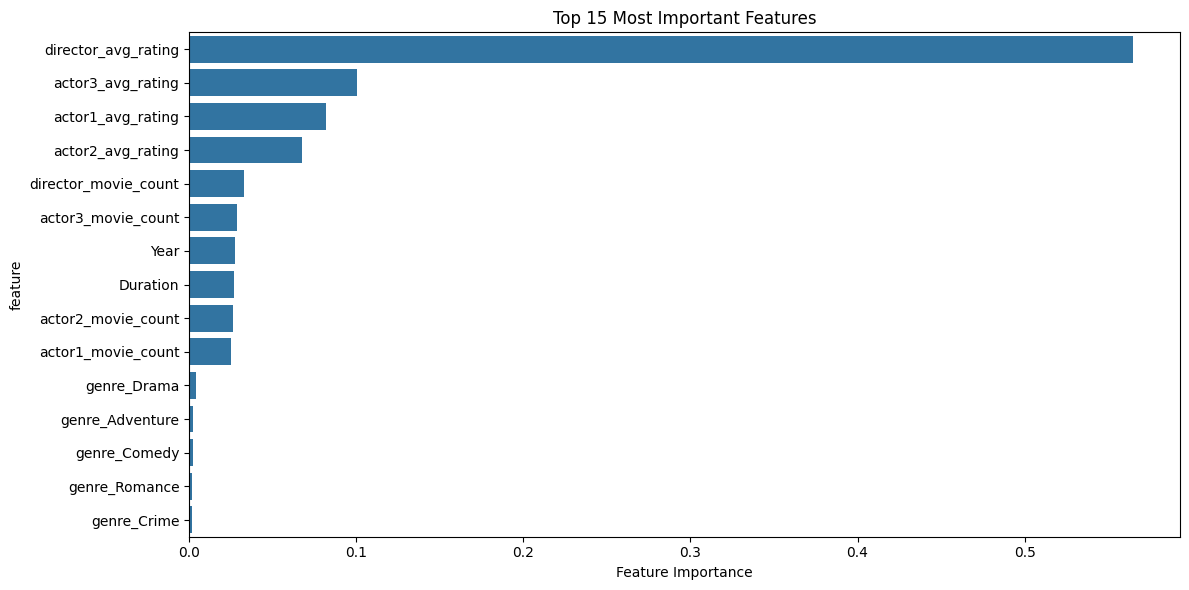

In [137]:
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

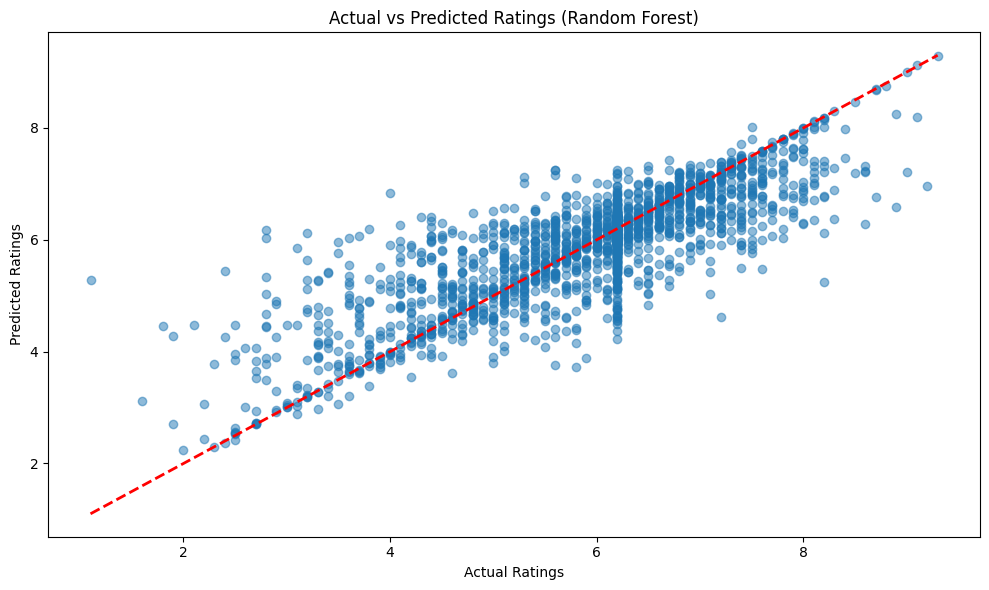

In [138]:
# 6. Visualization of Predictions
best_model_name = min(results.keys(), key=lambda k: results[k][0])  # Model with lowest RMSE
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions[best_model_name], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title(f'Actual vs Predicted Ratings ({best_model_name})')
plt.tight_layout()
plt.show()

In [139]:
# 7. Save the best model
best_model = models[best_model_name]
joblib.dump(best_model, 'movie_rating_predictor.joblib')

['movie_rating_predictor.joblib']

In [140]:
# Function to make predictions for new movies
def predict_rating(model, movie_data):
    """
    Predict rating for a new movie
    movie_data: DataFrame with the same features as training data
    """
    return model.predict(movie_data[feature_columns])

print("\nModel saved as 'movie_rating_predictor.joblib'")
print(f"Best performing model: {best_model_name}")


Model saved as 'movie_rating_predictor.joblib'
Best performing model: Random Forest
